In [1]:
import wrangle
import f_engineer
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [39]:
df = wrangle.get_zillow_project_data()
df.head()

Let me get that for you...


,parcelid,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,assessmentyear,logerror,transactiondate
0,11452343,3.0,4.0,2504.0,6037.0,NaN,33871723.0,-118318565.0,6009.0,1979.0,262584.0,2016.0,0.015371,2017-01-10
1,12967847,3.0,4.0,2077.0,6037.0,NaN,34162881.0,-117993177.0,11421.0,1979.0,950681.0,2016.0,-0.020910,2017-01-10
2,11765917,2.0,4.0,1722.0,6037.0,NaN,33998565.0,-118275430.0,5410.0,1909.0,207351.0,2016.0,0.043068,2017-01-10
3,13040720,2.0,3.0,1242.0,6037.0,NaN,34111289.0,-117852886.0,8328.0,1962.0,125553.0,2016.0,0.005903,2017-01-10
4,12402225,2.0,5.0,2359.0,6037.0,NaN,33881815.0,-118043413.0,4844.0,1966.0,708879.0,2016.0,-0.056877,2017-01-10


In [3]:
df = wrangle.zillow_proj_prep(df)
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 51834 entries, 0 to 52441
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathroomcnt           51834 non-null  float64
 1   bedroomcnt            51834 non-null  float64
 2   finishedsquarefeet12  51834 non-null  float64
 3   fips                  51834 non-null  float64
 4   garagecarcnt          51834 non-null  int64  
 5   latitude              51834 non-null  float64
 6   longitude             51834 non-null  float64
 7   lotsizesquarefeet     51834 non-null  float64
 8   yearbuilt             51834 non-null  float64
 9   taxvaluedollarcnt     51834 non-null  float64
 10  assessmentyear        51834 non-null  float64
 11  logerror              51834 non-null  float64
 12  transactiondate       51834 non-null  object 
dtypes: float64(11), int64(1), object(1)
memory usage: 5.5+ MB


In [4]:
# check data for nulls
df.isnull().sum()

bathroomcnt             0
bedroomcnt              0
finishedsquarefeet12    0
fips                    0
garagecarcnt            0
latitude                0
longitude               0
lotsizesquarefeet       0
yearbuilt               0
taxvaluedollarcnt       0
assessmentyear          0
logerror                0
transactiondate         0
dtype: int64

In [5]:
df.head()

,bathroomcnt,bedroomcnt,finishedsquarefeet12,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,assessmentyear,logerror,transactiondate
0,3.0,4.0,2504.0,6037.0,0,33871723.0,-118318565.0,6009.0,1979.0,262584.0,2016.0,0.015371,2017-01-10
1,3.0,4.0,2077.0,6037.0,0,34162881.0,-117993177.0,11421.0,1979.0,950681.0,2016.0,-0.020910,2017-01-10
2,2.0,4.0,1722.0,6037.0,0,33998565.0,-118275430.0,5410.0,1909.0,207351.0,2016.0,0.043068,2017-01-10
3,2.0,3.0,1242.0,6037.0,0,34111289.0,-117852886.0,8328.0,1962.0,125553.0,2016.0,0.005903,2017-01-10
4,2.0,5.0,2359.0,6037.0,0,33881815.0,-118043413.0,4844.0,1966.0,708879.0,2016.0,-0.056877,2017-01-10


In [6]:
# create a new dataframe with only longitude and latitude columns
location_data = df.loc[:, ['longitude', 'latitude']]
# drop longitude and latitude columns from original dataframe
df.drop(columns=['longitude', 'latitude'], inplace=True)

In [38]:
# split the dataframe into train, validate, and test
train, validate, test = wrangle.split_dataframe(df)
print(train.shape)
print(validate.shape)
print(test.shape)

(29026, 11)
(12441, 11)
(10367, 11)


In [8]:
# identify the columns correlated with the target
corr_matrix = train.corr()
corr_matrix['taxvaluedollarcnt'].sort_values(ascending=False)

taxvaluedollarcnt       1.000000
finishedsquarefeet12    0.623823
bathroomcnt             0.534441
bedroomcnt              0.279657
yearbuilt               0.186994
garagecarcnt            0.059343
fips                    0.024587
lotsizesquarefeet       0.022692
logerror               -0.011170
assessmentyear               NaN
Name: taxvaluedollarcnt, dtype: float64

In [22]:
# create X and y for train
# X_train should have only finishedsquarefeet12, bathroomcnt, bedroomcnt 
# y_train should have only taxvaluedollarcnt 
X_train1 = train[['finishedsquarefeet12']]
X_train2 = train[['bathroomcnt']]
X_train3 = train[['bedroomcnt']]
y_train = train['taxvaluedollarcnt']

In [10]:
# scale X_train
# X_train_scaled = f_engineer.scale_minmax(X_train)

In [11]:
# r, p_value = pearsonr(X_train['bathroomcnt'], X_train['finishedsquarefeet12'])
# print(f"The correlation coefficient(r) is {r} and the p-value is {p_value}")

The correlation coefficient(r) is 0.8470745954388398 and the p-value is 0.0


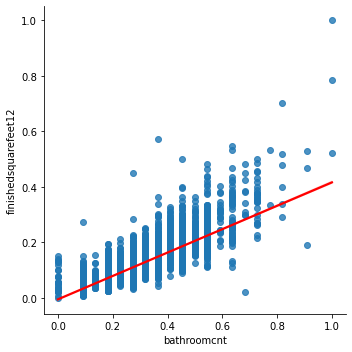

In [12]:
# # create a regression line scatter plot
# sns.lmplot(x='bathroomcnt', y='finishedsquarefeet12', data=X_train_scaled, line_kws={'color':'red'})
# plt.show()

In [13]:
predictions = pd.DataFrame({
    'actual': validate.taxvaluedollarcnt
})

In [23]:

# 1. make the thing
lm = LinearRegression()
# 2. fit the thing
lm.fit(X_train1, y_train)
# 3. use the thing (make predictions)
X_validate = validate[['finishedsquarefeet12']]
predictions['simple_lm'] = lm.predict(X_validate)

In [24]:
predictions.head()

,actual,simple_lm
17073,780176.0,371373.528561
20295,247558.0,362197.564030
20557,346957.0,95657.641944
40782,390842.0,821432.741265
20266,1082260.0,559699.276790


In [25]:
lm.coef_, lm.intercept_

(array([436.95069195]), -314639.0577931771)

In [26]:
print('taxvaluedollarcnt = {:.3f} * finishedsquarefeet12 + {:.3f}'.format(lm.coef_[0], lm.intercept_))

taxvaluedollarcnt = 436.951 * finishedsquarefeet12 + -314639.058


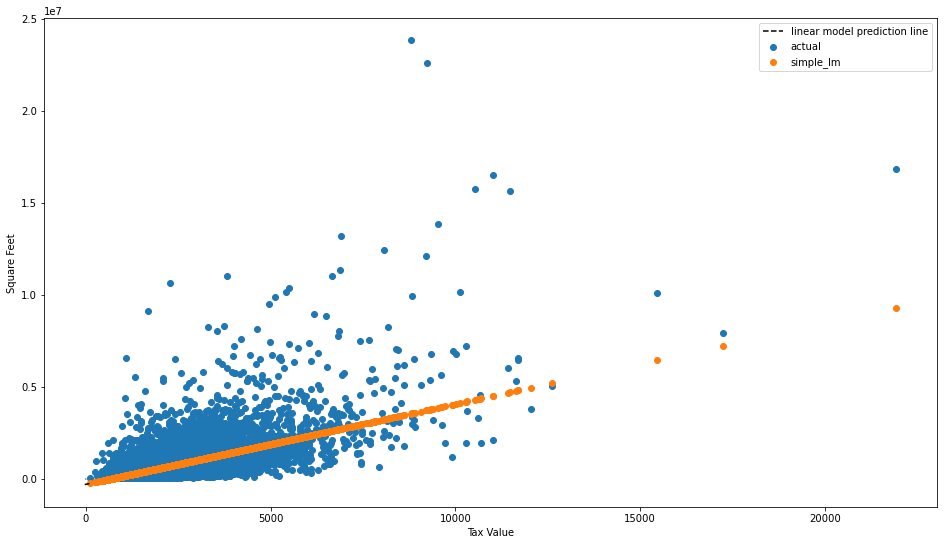

In [29]:
x_pred = np.array([-25, 100]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(16, 9))
plt.scatter(train.finishedsquarefeet12, train.taxvaluedollarcnt, label='actual')
plt.scatter(train.finishedsquarefeet12, lm.predict(train[['finishedsquarefeet12']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')

plt.xlabel('Tax Value')
plt.ylabel('Square Feet')
plt.legend()

In [30]:
# repeat the above steps for the other columns
# 2. fit the thing
lm.fit(X_train2, y_train)
# 3. use the thing (make predictions)
X_validate = validate[['bathroomcnt']]
predictions['simple_lm'] = lm.predict(X_validate)

In [31]:
lm.coef_, lm.intercept_

(array([369406.35523233]), -324865.79202180845)

In [32]:
print('taxvaluedollarcnt = {:.3f} * bathroomcnt + {:.3f}'.format(lm.coef_[0], lm.intercept_))

taxvaluedollarcnt = 369406.355 * bathroomcnt + -324865.792


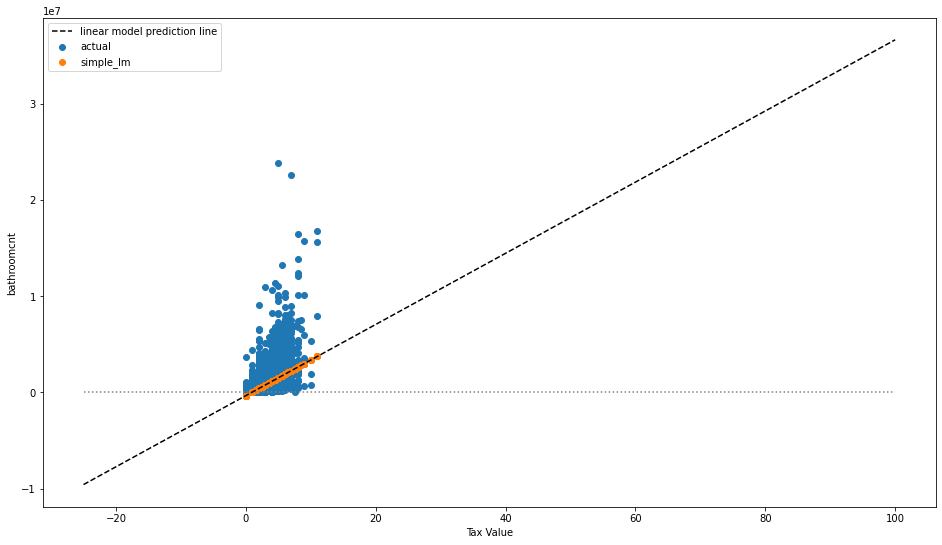

In [33]:
x_pred = np.array([-25, 100]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(16, 9))
plt.scatter(train.bathroomcnt, train.taxvaluedollarcnt, label='actual')
plt.scatter(train.bathroomcnt, lm.predict(train[['bathroomcnt']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')

plt.xlabel('Tax Value')
plt.ylabel('bathroomcnt')
plt.legend()

In [34]:
# repeat the above steps for the other columns
# 2. fit the thing
lm.fit(X_train3, y_train)
# 3. use the thing (make predictions)
X_validate = validate[['bedroomcnt']]
predictions['simple_lm'] = lm.predict(X_validate)

In [35]:
lm.coef_, lm.intercept_

(array([209201.24445237]), -168781.115466726)

In [36]:
print('taxvaluedollarcnt = {:.3f} * bedroomcnt + {:.3f}'.format(lm.coef_[0], lm.intercept_))

taxvaluedollarcnt = 209201.244 * bedroomcnt + -168781.115


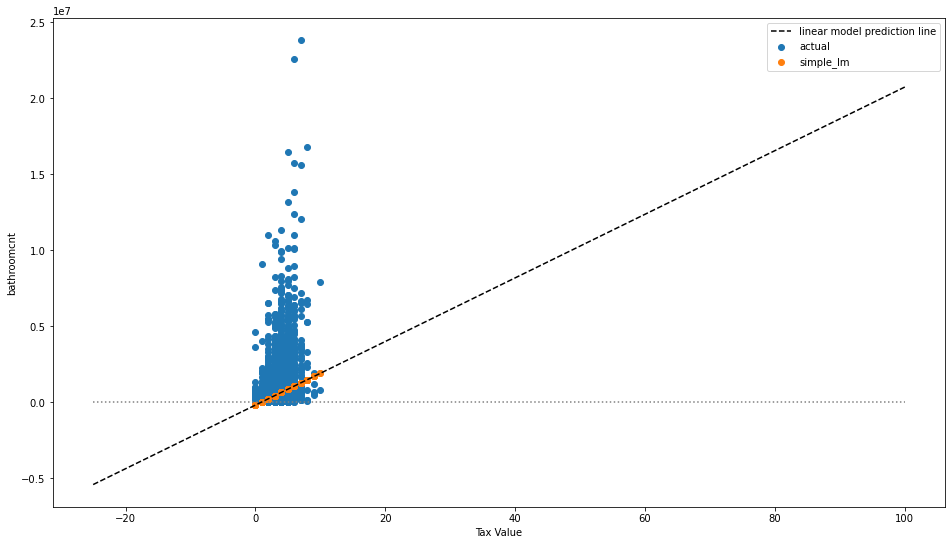

In [37]:
x_pred = np.array([-25, 100]).reshape(-1, 1)
y_pred = lm.predict(x_pred)

plt.figure(figsize=(16, 9))
plt.scatter(train.bedroomcnt, train.taxvaluedollarcnt, label='actual')
plt.scatter(train.bedroomcnt, lm.predict(train[['bedroomcnt']]), label='simple_lm')
plt.plot(x_pred, y_pred, ls='--', c='black', label='linear model prediction line')
plt.hlines(0, -25, 100, ls=':', color='grey')
plt.vlines(0, -10, 100, ls=':', color='grey')

plt.xlabel('Tax Value')
plt.ylabel('bathroomcnt')
plt.legend()